# Preprocessing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils


In [ ]:
import torch



# Device
device="cuda" if torch.cuda.is_available() else "cpu"

# Path of the model (saved/to save)
modelFolder = './models/'

# When True, retrain the whole model
retrain = True

# Downsample the dataset
ds = True

# Size of the split
trainSize = 0.75
valSize = 0.05
testSize = 0.20

# Specify number of seconds for the window. Default: 16
window_size = 16

# Model hyper-parameters
batch_size = 32
learning_rate = 1e-3

# Seed for reproducibility
seed = 42

# Classes to drop in the dataset
classes_to_drop=[
    'stabf','stab']



In [ ]:
import numpy as np
import os
import pandas as pd
import random

from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from sklearn.metrics import f1_score
from torch.utils.data import Dataset

import torch
import torch.nn as nn



def setSeed(seed=seed):
    """
    Setting the seed for reproducibility
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

setSeed()

def min_max_norm(self,col):
    self._data[col]=(self._data[col]-self._data[col].min())/(self._data[col].max()-self._data[col].min())


def std_scaler(self,col):
    self._data[col]=(self._data[col]-self._data[col].mean())/(self._data[col].std())


def f1(test_loader, model):
    f1 = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            outputs = model(data)
            pred = outputs.data.max(1, keepdim=True)[1]
            f1 += f1_score(labels, pred, average='macro')
    avg_f1 = f1/len(test_loader)
    return (avg_f1)


class CustomDataset(Dataset):
    def __init__(self, file_path='/content/new_dataset.csv', classes_to_drop=classes_to_drop, window_size=window_size, normalize=True, normalize_method='mean_std', auth=False, target=None):

        self._window_size=window_size
        self._data=pd.read_csv(file_path)

        # if auth==True:
        #     if target != 'J':
        #         self._data = self._data[self._data['stabf'].isin([target, 'J'])]
        #     else:
        #         self._data = self._data[self._data['stabf'].isin([target, 'I'])]

        #     self._data['stabf'] = self._data['stabf'].apply(lambda x: target if x == target else 'Z')
        #     self._data['stabf'] = self._data['stabf'].map({target: 1, 'Z': 0}).fillna(0).astype(int)


        # # Random Undersampling
        # X = self._data.drop('stabf', axis=1)
        # y = self._data['stabf']

        # # sampler = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)
        # # X_resampled, y_resampled = sampler.fit_resample(X, y)

        # # X_resampled['Class'] = y_resampled
        # self._data = X

        # The data is sorted by Class A,B,C the indexes of the dataframe have restarted by ignore index
        self._data = self._data.sort_values(by=['stabf'], inplace=False,ignore_index = True)

        # class_uniq contains the letters of the drivers A,B and it loops across all of them
        for class_uniq in list(self._data['stabf'].unique()):
            # Find the total number of elements belonging to a class
            tot_number=sum(self._data['stabf']==class_uniq)
            # Number of elements to drop so that the class element is divisible by window size
            to_drop=tot_number%window_size
            # Returns the index of the first element of the class
            index_to_start_removing=self._data[self._data['stabf']==class_uniq].index[0]
            # Drop element from first element to the element required
            self._data.drop(self._data.index[index_to_start_removing:index_to_start_removing+to_drop],inplace=True)


        # Resetting index of dataframe after dropping values
        self._data = self._data.reset_index()
        self._data = self._data.drop(['index'], axis=1)

        index_starting_class=[] # This array contains the starting index of each class in the df
        for class_uniq in list(self._data['stabf'].unique()):
            # Appending the index of first element of each clas
            index_starting_class.append(self._data[self._data['stabf']==class_uniq].index[0])

        # Create the sequence of indexs of the windows
        sequences=[]
        for i in range(len(index_starting_class)):
            # Check if beginning of next class is there
            if i!=len(index_starting_class)-1:
                ranges=np.arange(index_starting_class[i], index_starting_class[i+1])
            else:
                ranges = np.arange(index_starting_class[i], len(self._data))
            for j in range(0,len(ranges),int(self._window_size/2)):
                if len(ranges[j:j+self._window_size])==16:
                    sequences.append(ranges[j:j+self._window_size])
        self._sequences=sequences


        # Take only the 'Class' which are the actual labels and store it in the labels of self
        self._labels=self._data['stabf']
        # Dropping columns which have constant measurements because they would return nan in std
        self._data.drop(classes_to_drop, inplace=True, axis=1)

        # Function to normalize the data either with min_max or mean_std
        if normalize and not auth:
            for col in self._data.columns:
                if normalize_method=='min_max':
                    min_max_norm(self,col)
                elif normalize_method=="mean_std":
                    std_scaler(self,col)

        # Create the array holding the windowed multidimensional arrays
        X=np.empty((len(sequences), self._window_size, len(self._data.columns)))
        y=[]

        for n_row, sequence in enumerate(sequences):
            X[n_row,:,:]=self._data.iloc[sequence]
            # The corresponding driver of the sequence is the driver at first sequence
            y.append(self._labels[sequence[0]])

        assert len(y)==len(X)
        # Assign the windowed dataset to the X of self
        self._X= X

        # Targets is a transformed version of y with drivers are encoded into 0 to 9
        targets = preprocessing.LabelEncoder().fit_transform(y)
        class_labels = encoder.classes_
        for code, label in enumerate(class_labels):
          print(f'Code: {code} -> Label: {label}')
        targets = torch.as_tensor(targets)  # Just converting it to a pytorch tensor
        self._y=targets # Assign it to y of self


    def __len__(self):
        return len(self._X)


    def __getitem__(self, index):
        return torch.FloatTensor(self._X[index,:,:]), self._y[index]


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    y_true = []
    y_pred = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs
        labels = labels

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Collect predictions and true labels
        y_true += labels.data.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()

    # Calculate accuracy and loss
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    epoch_f1 = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, epoch_acc, epoch_f1


def evaluateBinary(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    y_true = []
    y_pred = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            # loss = criterion(outputs, labels)
            loss = criterion(outputs.squeeze(), labels.float())

        _, preds = torch.max(outputs, 1)
        # preds = (outputs > 0.5).float()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Collect predictions and true labels
        y_true += labels.data.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()

    # Calculate accuracy and loss
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    epoch_f1 = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, epoch_acc, epoch_f1



In [ ]:
dataset_path = '/content/smart_grid_stability_augmented.csv'

df = pd.read_csv(dataset_path)
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,unstable


In [ ]:
# Display feature indices
print("Feature Indices:")
for idx, column in enumerate(df.columns):
    print(f"{idx}: {column}")

Feature Indices:
0: tau1
1: tau2
2: tau3
3: tau4
4: p1
5: p2
6: p3
7: p4
8: g1
9: g2
10: g3
11: g4
12: stab
13: stabf


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['stabf'] = encoder.fit_transform(df['stabf'])

# Retrieve the mapping of numerical codes to original class labels
class_labels = encoder.classes_

# Display the mapping
for code, label in enumerate(class_labels):
    print(f'Code: {code} -> Label: {label}')
df

Code: 0 -> Label: stable
Code: 1 -> Label: unstable


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,0
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [ ]:
df.to_csv('new_dataset.csv', index=False)
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,0
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [ ]:
import torch
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [ ]:
a = CustomDataset()

# Defining sizes
train_size = int(trainSize * len(a))
val_size = int(valSize * len(a))
test_size = len(a)-train_size-val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    a, [train_size, val_size, test_size])


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           drop_last=True)

validation_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

Code: 0 -> Label: stable
Code: 1 -> Label: unstable


In [ ]:
pip install adversarial-robustness-toolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.1 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

# LSTM model for stability prediction

In [ ]:
import torch.optim as optim


class RNNBinaryClassification(torch.nn.Module):
    def __init__(self, batch_size, window_size, num_features, dropout_rate=0.5):
        super(RNNBinaryClassification, self).__init__()
        self.rnn1 = torch.nn.LSTM(num_features, 220, batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc = torch.nn.Linear(440, 1)  # Output size is 1 for binary classification
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        rnn1_out, _ = self.rnn1(x)
        rnn1_out = self.dropout(rnn1_out[:, -1, :])
        fc_out = self.fc(rnn1_out)
        out = self.sigmoid(fc_out)
        return out

model = RNNBinaryClassification(batch_size, window_size, 12).to(device)
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

retrain = False

if not os.path.exists('./models/rnn_auth.pt') or retrain:
    # Training loop
    for epoch in range(10):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)

        print(f'[💪 EPOCH {epoch+1}/{10}] Loss: {average_loss:.3f}')

[💪 EPOCH 1/10] Loss: 0.068
[💪 EPOCH 2/10] Loss: 0.009
[💪 EPOCH 3/10] Loss: 0.008
[💪 EPOCH 4/10] Loss: 0.002
[💪 EPOCH 5/10] Loss: 0.003
[💪 EPOCH 6/10] Loss: 0.001
[💪 EPOCH 7/10] Loss: 0.000
[💪 EPOCH 8/10] Loss: 0.000
[💪 EPOCH 9/10] Loss: 0.000
[💪 EPOCH 10/10] Loss: 0.000


In [ ]:
# Calculate accuracy
correct_predictions = 0
total_samples = 0

y_true = []
y_pred = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    predictions = (outputs > 0.5).float()

    for p, l in zip(predictions, labels.float()):
        if p == l:
            correct_predictions += 1

    total_samples += labels.size(0)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

acc = correct_predictions/total_samples
f1 = f1_score(y_true, y_pred, average='binary')

print('[👑 TEST GRU AUTH]\n')
print(f'[🎯 ACCURACY] {acc:.3f}')
print(f'[⚖️ F1 SCORE] {f1:.3f}')

[👑 TEST GRU AUTH]

[🎯 ACCURACY] 0.999
[⚖️ F1 SCORE] 0.999


In [ ]:
from sklearn.metrics import f1_score

def introduce_feature_anomalies(data, anomaly_ratio=1.0, noise_factor=5.0, scale_factor=2.0, outlier_value=10.0):
    """
    Introduces anomalies in specific features by applying out-of-range values,
    Gaussian noise injection, and scaling drift.

    Args:
        data (Tensor): The dataset tensor.
        anomaly_ratio (float): The percentage of samples to modify.
        noise_factor (float): Scale of Gaussian noise added.
        scale_factor (float): Factor for scaling drift.
        outlier_value (float): Extreme out-of-range replacement.

    Returns:
        Anomalous dataset and a mask indicating which samples were modified.
    """
    num_anomaly_samples = int(len(data) * anomaly_ratio)
    anomalous_data = data.clone()
    anomaly_mask = torch.zeros(len(data), dtype=torch.bool)  # Track anomalies

    # important_indices = [10,3,0,9,2]  # tau1-tau4, g4, g1-g3
    selected_features = [0,1,2,3,4,5,6,7,8,9,10,11]
    selected_features = torch.tensor(selected_features, dtype=torch.long)
    important_indices = selected_features[torch.randperm(len(selected_features))]
    # important_indices = [10,3,0,9,2,4,5,6,7]  # tau1-tau4, g4, g1-g3
    anomaly_indices = torch.randperm(len(data))[:num_anomaly_samples]

    for idx in anomaly_indices:
        feature_choice = torch.randint(2, 3, (1,)).item()  # Randomly select anomaly type
        selected_features = torch.tensor(important_indices, dtype=torch.long)
        # feature_choice= 2

        if feature_choice == 0:
            # Out-of-range anomaly
            anomalous_data[idx, :, selected_features] = outlier_value * torch.sign(torch.randn(selected_features.shape))
        elif feature_choice == 1:
            # Gaussian noise injection
            noise = torch.randn_like(anomalous_data[idx, :, selected_features]) * noise_factor
            anomalous_data[idx, :, selected_features] += noise

        elif feature_choice == 2:
            # Sudden Drop or Surge (50-80% shift)
            shift_factor = torch.rand(selected_features.shape) * 5 + 8  # Between 50% and 80%
            direction = torch.randint(0, 2, selected_features.shape) * 2 - 1  # Randomly -1 or +1
            anomalous_data[idx, :, selected_features] *= 1 + (direction * shift_factor)
        elif feature_choice == 3:
            # Stuck Value (hold a previous timestep value constant)
            time_step = torch.randint(0, anomalous_data.shape[1], (1,)).item()
            stuck_value = anomalous_data[idx, time_step, selected_features]
            anomalous_data[idx, :, selected_features] = stuck_value.unsqueeze(0).repeat(
                anomalous_data.shape[1], 1
            )

        anomaly_mask[idx] = True

    return anomalous_data, anomaly_mask

# Apply anomalies to test data
anomalous_test_data = []
anomalous_labels = []
anomaly_mask_all = []

for inputs, labels in test_loader:
    inputs, anomaly_mask = introduce_feature_anomalies(inputs)
    anomalous_test_data.append(inputs)
    anomalous_labels.append(labels)
    anomaly_mask_all.append(anomaly_mask)

# Convert lists to tensors
anomalous_test_data = torch.cat(anomalous_test_data, dim=0)
anomalous_labels = torch.cat(anomalous_labels, dim=0)
anomaly_mask_all = torch.cat(anomaly_mask_all, dim=0)

# Create a new DataLoader for the anomalous dataset
anomalous_test_loader = torch.utils.data.DataLoader(
    list(zip(anomalous_test_data, anomalous_labels)),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
correct_predictions = 0
total_samples = 0

y_true = []
y_pred = []

# Evaluate on anomalous test set (only for affected samples)
for inputs, labels in anomalous_test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs= model(inputs)
    predictions = (outputs > 0.5).float()

    # Apply anomaly mask to focus only on affected samples
    affected_preds = predictions[anomaly_mask_all[total_samples:total_samples+len(labels)]]
    affected_labels = labels[anomaly_mask_all[total_samples:total_samples+len(labels)]]

    # Count correct predictions only for affected samples
    for p, l in zip(affected_preds, affected_labels):
        if p == l:
            correct_predictions += 1

    total_samples += len(affected_labels)
    y_true.extend(affected_labels.cpu().numpy())
    y_pred.extend(affected_preds.cpu().numpy())

# Compute evaluation metrics on affected samples
acc = correct_predictions / total_samples
f1 = f1_score(y_true, y_pred, average='binary')
anom_ratio = sum(y_pred) / len(y_pred)

print(f"[📊 DETECTED ANOMALY RATIO]: {anom_ratio}")
print('[🚨 TEST ON FEATURE-BASED ANOMALIES]\n')
print(f'[🎯 ACCURACY] {acc:.3f}')
print(f'[⚖️ F1 SCORE] {f1:.3f}')


<ipython-input-21-b9d3f1ed9983>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  selected_features = torch.tensor(important_indices, dtype=torch.long)


[📊 DETECTED ANOMALY RATIO]: [0.5400815]
[🚨 TEST ON FEATURE-BASED ANOMALIES]

[🎯 ACCURACY] 0.571
[⚖️ F1 SCORE] 0.639


# Modified GAN-GRID against LSTM-based stability predition

In [ ]:
import torch
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [ ]:
class Generator(nn.Module):
    def __init__(self, batch_size, window_size, num_features,):
        super(Generator, self).__init__()
        self.batch_size = batch_size
        self.num_features = num_features
        self.window_size = window_size
        self.layer1 = nn.Linear(num_features, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, batch_size*window_size)
        self.layer5 = nn.Linear(batch_size*window_size, num_features)

        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.leaky_relu(self.layer2(x))
        x = self.leaky_relu(self.layer3(x))
        x = self.leaky_relu(self.layer4(x))
        x = self.layer5(x)
        return x

In [ ]:
def train_gan(generator, surrogate, label, train_loader, num_epochs=100, lr=0.001, device=torch.device('cpu'), ml=False, num_episodes=150):
    losses = []

    if not ml:
        generator = generator.to(device)
        surrogate = surrogate.to(device)

    # Define the loss function and optimizer
    binary_cross_entropy_loss = nn.BCEWithLogitsLoss()
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

    # Define the reinforcement learning parameters
    max_episode_length = 10
    alpha = 0.1
    gamma = 0.9

    # Define the feature mask for indices 4, 5, 6, 7
    feature_mask = torch.zeros(12, device=device)
    feature_mask[4:8] = 1  # Only focus on features 4, 5, 6, 7

    for episode in range(num_episodes):
        # Initialize the latent input and the episode reward
        latent_input = torch.randn(4, 16, 12).to(device)
        episode_reward = 0

        for step in range(max_episode_length):
            # Generate a sample with the current latent input
            fake_input = generator(latent_input)

            # Apply the feature mask to focus on indices 4, 5, 6, 7
            fake_input = fake_input * feature_mask + latent_input * (1 - feature_mask)

            # Evaluate the sample with the surrogate model
            if not ml:
                surrogate_output = surrogate(fake_input)
            else:
                surrogate_output = []
                for group in fake_input:
                    flat_group = group.view(-1, group.size(-1)).detach().numpy()
                    probabilities, _ = surrogate.predict_proba(flat_group)
                    mean_probabilities = np.mean(probabilities, axis=0)
                    surrogate_output.append(mean_probabilities)
                with torch.no_grad():
                    surrogate_output = torch.tensor(surrogate_output, requires_grad=True)

            predictions = (surrogate_output > 0.5).float()
            targets = torch.randint_like(predictions, 0, 2)
            reward = (predictions == targets).float().mean().item()
            episode_reward += reward

            # Update the latent input using reinforcement learning, masked for selected features
            td_error = reward - episode_reward
            latent_update = alpha * td_error * gamma**step * torch.randn_like(latent_input)
            latent_input = latent_input + latent_update * feature_mask

        # Update the generator using the final latent input of the episode
        generator_optimizer.zero_grad()
        fake_input = generator(latent_input)
        fake_input = fake_input * feature_mask + latent_input * (1 - feature_mask)

        if not ml:
            surrogate_output = surrogate(fake_input)
        else:
            surrogate_output = []
            for group in fake_input:
                flat_group = group.view(-1, group.size(-1)).detach().numpy()
                probabilities, _ = surrogate.predict_proba(flat_group)
                mean_probabilities = np.mean(probabilities, axis=0)
                surrogate_output.append(mean_probabilities)
            with torch.no_grad():
                surrogate_output = torch.tensor(surrogate_output, requires_grad=True)

        target_labels = torch.full_like(surrogate_output, label)
        generator_loss = binary_cross_entropy_loss(surrogate_output, target_labels)

        generator_loss.backward()
        generator_optimizer.step()

        losses.append(generator_loss.item())

        if episode % 10 == 0:
            print(f'[⏭️ EP {episode}/{num_episodes} | D{label}] LOSS: {round(generator_loss.item(), 3)}')

    print()
    return generator, losses


Restart the process if the gennrator did not converge in the first try ( you might have to restart the process a couple of times to reach the best ASR , it is also recommended to use GPU)

In [ ]:
lr = 3e-3

generators = []
losses = []

inputs, classes = next(iter(train_loader))

# For each driver
for d in range(1):
        print(f'[🤖 GENERATORS] Label {d}')

        batch_size, window_size, num_features = inputs.shape
        generator = Generator(batch_size, window_size, num_features)
        surrogate_model = model

        generator, loss = train_gan(generator, surrogate_model, train_loader=train_loader, num_epochs=20, lr=lr, label=0, ml=False, num_episodes=100)
        print()

        generators.append(generator)
        losses.append(loss)

[🤖 GENERATORS] Label 0
[⏭️ EP 0/100 | D0] LOSS: 0.849
[⏭️ EP 10/100 | D0] LOSS: 0.806
[⏭️ EP 20/100 | D0] LOSS: 0.709
[⏭️ EP 30/100 | D0] LOSS: 0.693
[⏭️ EP 40/100 | D0] LOSS: 0.693
[⏭️ EP 50/100 | D0] LOSS: 0.693
[⏭️ EP 60/100 | D0] LOSS: 0.693
[⏭️ EP 70/100 | D0] LOSS: 0.698
[⏭️ EP 80/100 | D0] LOSS: 0.693
[⏭️ EP 90/100 | D0] LOSS: 0.721




In [ ]:
results = []

threshold = 0.5
device = torch.device("cpu")
model.to(device)

for i in range(1):
    predicted_labels = []
    generator = generators[i].to(device)

    for inputs, labels in test_loader:  # Include labels
        input_batch = inputs.to(device)
        labels = labels.to(device)

        # Filter inputs with label 1
        positive_inputs = input_batch[labels == 1]

        if positive_inputs.size(0) > 0:  # Ensure there are positive inputs
            # Generate data
            generated_data = generator(torch.randn(positive_inputs.size(0), 16, 12).to(device))
            modifiable_feature_indices = [4,5,6,7]
            # # Create a binary mask (1 means this feature will be modified, 0 means it won't)
            mask = np.zeros((positive_inputs.size(0), window_size, num_features))
            mask[:, :, modifiable_feature_indices] = 1  # Mark features to modify with 1
            mask = torch.tensor(mask, dtype=torch.float32)  # Convert mask to a PyTorch tensor with float32 type
            generated_data = generated_data * mask + positive_inputs * (1 - mask)

            # Add the result to the ones tensor
            final_result = generated_data.to(device)

            # Get the surrogate outputs for each sample in the generated data
            surrogate_outputs = model(final_result)

            # Apply the threshold for binary classification
            predicted_labels_batch = (surrogate_outputs > threshold).float()

            # Append the predicted labels to the lists
            predicted_labels.extend(predicted_labels_batch.squeeze().tolist())  # Squeeze the tensor

    # Compute ASR considering only filtered inputs
    asr = predicted_labels.count(0) / len(predicted_labels) if predicted_labels else 0
    results.append(asr)
    print(f'[👑 {i}] ASR: {round(asr, 3)}')


[👑 0] ASR: 0.944


# GRU-based Anomoly Detection

In [ ]:
import torch
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [ ]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch, ProjectedGradientDescentNumpy, CarliniLInfMethod, CarliniWagnerASR,UniversalPerturbation
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion.iterative_method import BasicIterativeMethod
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    input_shape=(12,),
    nb_classes=2,
    # device_type="cpu"
    device_type="gpu" if torch.cuda.is_available() else "cpu"
)
# Define the RNN model for binary classification
class RNNBinaryClassification(nn.Module):
    def __init__(self, batch_size, window_size, num_features, dropout_rate=0.1):
        super(RNNBinaryClassification, self).__init__()
        self.rnn1 = nn.GRU(num_features, 220, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(440, 1)  # Output size is 1 for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        rnn1_out, _ = self.rnn1(x)
        rnn1_out = self.dropout(rnn1_out[:, -1, :])
        fc_out = self.fc(rnn1_out)
        out = self.sigmoid(fc_out)
        return out

# Initialize model, criterion, optimizer
model1 = RNNBinaryClassification(batch_size, window_size, 12).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# Generate adversarial inputs using FGSM
n_epochs = 50
start_time = time.time()
# Define a range of epsilon values from 0.05 to 0.50 with a step of 0.05

# Training loop
for epoch in range(n_epochs):
    model1.train()
    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, _ in train_loader:  # Get only inputs from the real dataset
        inputs = inputs.to(device)
        modifiable_feature_indices = np.random.choice(num_features, size=np.random.randint(2, 10), replace=False)
        mask = np.zeros((batch_size, window_size, num_features))
        mask[:, :, modifiable_feature_indices] = 1  # Mark features to modify with 1
        mask = torch.tensor(mask, dtype=torch.float32)  # Convert mask to a PyTorch tensor with float32 type
        # eps = np.random.choice(epsilon_values)
        fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.1)
        adv_inputs_fgsm = fgsm_attack.generate(x=inputs.cpu().numpy())
        adv_inputs_fgsm = torch.tensor(adv_inputs_fgsm).to(device)
        adv_inputs_fgsm = adv_inputs_fgsm * mask + inputs * (1 - mask)



        # Combine real, adversarial, and generated data
        combined_data = torch.cat([inputs, adv_inputs_fgsm], dim=0)

        # Create labels: 0 for real data, 1 for generated and adversarial data
        real_labels = torch.zeros(inputs.size(0), device=device)
        adv_labels = torch.ones(adv_inputs_fgsm.size(0), device=device)
        combined_labels = torch.cat([real_labels, adv_labels], dim=0)

        # Forward pass
        outputs = model1(combined_data).squeeze()

        # Compute loss and backpropagation
        loss = criterion(outputs, combined_labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss
        train_loss += loss.item()

        # Convert model outputs to binary predictions
        preds = (outputs > 0.5).float()

        # Update correct predictions and total samples
        correct_predictions += torch.sum(preds == combined_labels).item()
        total_samples += combined_labels.size(0)

    # Calculate metrics for the epoch
    train_loss /= len(train_loader)
    train_acc = correct_predictions / total_samples

    print(f"Epoch {epoch+1}/{n_epochs} -- Train Loss: {train_loss:.4f} -- Train Accuracy: {train_acc:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

total_params = sum(p.numel() for p in model1.parameters())
print(f"Total Model Parameters: {total_params}")


Epoch 1/50 -- Train Loss: 0.6709 -- Train Accuracy: 0.5777
Epoch 2/50 -- Train Loss: 0.5810 -- Train Accuracy: 0.6815
Epoch 3/50 -- Train Loss: 0.4696 -- Train Accuracy: 0.7784
Epoch 4/50 -- Train Loss: 0.4359 -- Train Accuracy: 0.7946
Epoch 5/50 -- Train Loss: 0.3642 -- Train Accuracy: 0.8446
Epoch 6/50 -- Train Loss: 0.3909 -- Train Accuracy: 0.8306
Epoch 7/50 -- Train Loss: 0.4242 -- Train Accuracy: 0.8090
Epoch 8/50 -- Train Loss: 0.3647 -- Train Accuracy: 0.8498
Epoch 9/50 -- Train Loss: 0.3343 -- Train Accuracy: 0.8643
Epoch 10/50 -- Train Loss: 0.3458 -- Train Accuracy: 0.8557
Epoch 11/50 -- Train Loss: 0.3447 -- Train Accuracy: 0.8573
Epoch 12/50 -- Train Loss: 0.3300 -- Train Accuracy: 0.8697
Epoch 13/50 -- Train Loss: 0.3704 -- Train Accuracy: 0.8404
Epoch 14/50 -- Train Loss: 0.3318 -- Train Accuracy: 0.8622
Epoch 15/50 -- Train Loss: 0.3460 -- Train Accuracy: 0.8562
Epoch 16/50 -- Train Loss: 0.3138 -- Train Accuracy: 0.8738
Epoch 17/50 -- Train Loss: 0.3475 -- Train Accura

In [ ]:
# Modify test data with feature anomalies and track affected samples
anomalous_test_data = []
anomalous_labels = []

for inputs, labels in test_loader:
    inputs, anomaly_mask = introduce_feature_anomalies(inputs)  # Apply feature anomalies and get mask

    # Filter only anomalous samples
    anomalous_inputs = inputs[anomaly_mask]
    anomalous_labels_batch = labels[anomaly_mask]

    anomalous_test_data.append(anomalous_inputs)
    anomalous_labels.append(anomalous_labels_batch)

# Convert lists to tensors if there are anomalous samples
if anomalous_test_data:
    anomalous_test_data = torch.cat(anomalous_test_data, dim=0)
    anomalous_labels = torch.cat(anomalous_labels, dim=0)

    # Create a new DataLoader with only anomalous samples
    anomalous_test_loader = torch.utils.data.DataLoader(
        list(zip(anomalous_test_data, anomalous_labels)),
        batch_size=batch_size,
        shuffle=False,
        drop_last=True
    )
else:
    raise ValueError("No anomalous samples detected. Adjust anomaly parameters if needed.")


<ipython-input-21-b9d3f1ed9983>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  selected_features = torch.tensor(important_indices, dtype=torch.long)


In [ ]:
from tqdm import tqdm
model1.to(device)
# Define a range of epsilon values from 0.05 to 0.50 with a step of 0.05
epsilons = torch.arange(0.05, 0.55, 0.05)
modifiable_feature_indices = [4,5,6,7]
# Create a binary mask (1 means this feature will be modified, 0 means it won't)
mask = np.zeros((batch_size, window_size, num_features))
mask[:, :, modifiable_feature_indices] = 1  # Mark features to modify with 1
mask = torch.tensor(mask, dtype=torch.float32)  # Convert mask to a PyTorch tensor with float32 type
# Initialize FGSM, BIM, and PGD attacks (epsilon will be set inside the loop)
for epsilon in tqdm(epsilons, desc="Processing epsilon values"):

    # Initialize attack methods for this epsilon value
    fgsm_attack = FastGradientMethod(estimator=classifier, eps=epsilon.item())
    bim_attack = BasicIterativeMethod(estimator=classifier, eps=epsilon.item(), max_iter=10, verbose=False)
    pgd_attack = ProjectedGradientDescentNumpy(estimator=classifier, eps=epsilon.item(), max_iter=10, verbose=False)
    # rfgsm_attack = RFGSM(model=model1, eps=epsilon.item(), alpha=2/255, steps=10)
    # eotpgd_attack = EOTPGD(model=model1, eps=epsilon.item(), alpha=2/255, steps=10, eot_iter=2)

    # Initialize lists to store predictions and labels for each attack type
    real_preds, real_labels = [], []
    fgsm_preds, fgsm_labels = [], []
    bim_preds, bim_labels = [], []
    pgd_preds, pgd_labels = [], []
    rfgsm_preds, rfgsm_labels = [], []
    generated_preds, generated_labels = [], []
    anomoly_preds, anomoly_labels = [], []

    # Loop through the test set for real data (label = 0)
    for inputs, _ in test_loader:
        inputs = inputs.to(device)

        # --- Real Data ---
        real_outputs = model1(inputs).squeeze()
        real_pred = (real_outputs > 0.5).float()
        real_preds.extend(real_pred.cpu().numpy())
        real_labels.extend(torch.zeros(real_pred.size(0)).cpu().numpy())

        # --- FGSM Attack ---
        adv_data_fgsm = fgsm_attack.generate(x=inputs.cpu().numpy())  # FGSM attack generation
        adv_data_fgsm = torch.tensor(adv_data_fgsm).to(device)
        adv_outputs_fgsm = model1(adv_data_fgsm).squeeze()
        fgsm_pred = (adv_outputs_fgsm > 0.5).float()
        fgsm_preds.extend(fgsm_pred.cpu().numpy())
        fgsm_labels.extend(torch.ones(fgsm_pred.size(0)).cpu().numpy())  # FGSM labels are 1

        # --- BIM Attack ---
        adv_data_bim = bim_attack.generate(x=inputs.cpu().numpy())  # BIM attack generation
        adv_data_bim = torch.tensor(adv_data_bim).to(device)
        adv_outputs_bim = model1(adv_data_bim).squeeze()
        bim_pred = (adv_outputs_bim > 0.5).float()
        bim_preds.extend(bim_pred.cpu().numpy())
        bim_labels.extend(torch.ones(bim_pred.size(0)).cpu().numpy())  # BIM labels are 1

        # --- PGD Attack ---
        adv_data_pgd = pgd_attack.generate(x=inputs.cpu().numpy())  # PGD attack generation
        adv_data_pgd = torch.tensor(adv_data_pgd).to(device)
        adv_outputs_pgd = model1(adv_data_pgd).squeeze()
        pgd_pred = (adv_outputs_pgd > 0.5).float()
        pgd_preds.extend(pgd_pred.cpu().numpy())
        pgd_labels.extend(torch.ones(pgd_pred.size(0)).cpu().numpy())  # PGD labels are 1

    total_samples = 0  # Reset total_samples before the second loop

    for inputs1, _ in anomalous_test_loader:

        inputs1 = inputs1.to(device)
        anomoly_outputs = model1(inputs1).squeeze()
        anomoly_pred = (anomoly_outputs > 0.5).float()
        # drifted_preds = anomoly_pred[drift_mask_all[total_samples:total_samples+inputs1.size(0)]]
        anomoly_preds.extend(anomoly_pred.cpu().numpy())
        anomoly_labels.extend(torch.ones(anomoly_pred.size(0)).cpu().numpy())
        total_samples += inputs1.size(0)


    # Generate fake data using the generator (label = 1)
    for _ in range(len(test_loader)):
        generated_data = generator(torch.randn(inputs.size(0), 16, 12).to(device))
        generated_data = generated_data * mask + inputs * (1 - mask)
        generated_outputs = model1(generated_data).squeeze()
        gen_pred = (generated_outputs > 0.5).float()
        generated_preds.extend(gen_pred.cpu().numpy())
        generated_labels.extend(torch.ones(gen_pred.size(0)).cpu().numpy())  # Generated data labels are 1

    # Calculate metrics for each type of data and attack
    def calculate_metrics(labels, preds, attack_name, pos_label=1):
        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, pos_label=pos_label)
        recall = recall_score(labels, preds, pos_label=pos_label)
        f1 = f1_score(labels, preds, pos_label=pos_label)
        print(f"--- {attack_name} --- for epsilon {epsilon:.2f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print()

    # Real data metrics (compute metrics for class 0)
    calculate_metrics(real_labels, real_preds, "Real Data", pos_label=0)

    # FGSM attack metrics
    calculate_metrics(fgsm_labels, fgsm_preds, "FGSM Attack")

    # BIM attack metrics
    calculate_metrics(bim_labels, bim_preds, "BIM Attack")

    # PGD attack metrics
    calculate_metrics(pgd_labels, pgd_preds, "PGD Attack")


    calculate_metrics(anomoly_labels, anomoly_preds, "Generated Anomoly")


    # calculate_metrics(rfgsm_labels, rfgsm_preds, "RFGSM Attack")

    # calculate_metrics(eotpgd_labels, eotpgd_preds, "EOTPGD Attack")

    # Generated data metrics
    calculate_metrics(generated_labels, generated_preds, "Generated Data")






Processing epsilon values:  10%|█         | 1/10 [00:09<01:21,  9.01s/it]

--- Real Data --- for epsilon 0.05
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.05
Accuracy: 0.9810
Precision: 1.0000
Recall: 0.9810
F1-Score: 0.9904

--- BIM Attack --- for epsilon 0.05
Accuracy: 0.9885
Precision: 1.0000
Recall: 0.9885
F1-Score: 0.9942

--- PGD Attack --- for epsilon 0.05
Accuracy: 0.9885
Precision: 1.0000
Recall: 0.9885
F1-Score: 0.9942

--- Generated Anomoly --- for epsilon 0.05
Accuracy: 0.9844
Precision: 1.0000
Recall: 0.9844
F1-Score: 0.9921

--- Generated Data --- for epsilon 0.05
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values:  20%|██        | 2/10 [00:21<01:30, 11.28s/it]

--- Real Data --- for epsilon 0.10
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.10
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.10
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.10
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.10
Accuracy: 0.9857
Precision: 1.0000
Recall: 0.9857
F1-Score: 0.9928

--- Generated Data --- for epsilon 0.10
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values:  30%|███       | 3/10 [00:31<01:15, 10.74s/it]

--- Real Data --- for epsilon 0.15
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.15
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.15
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.15
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.15
Accuracy: 0.9857
Precision: 1.0000
Recall: 0.9857
F1-Score: 0.9928

--- Generated Data --- for epsilon 0.15
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values:  40%|████      | 4/10 [00:39<00:57,  9.54s/it]

--- Real Data --- for epsilon 0.20
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.20
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.20
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.20
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.20
Accuracy: 0.9851
Precision: 1.0000
Recall: 0.9851
F1-Score: 0.9925

--- Generated Data --- for epsilon 0.20
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values:  50%|█████     | 5/10 [00:48<00:46,  9.22s/it]

--- Real Data --- for epsilon 0.25
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.25
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.25
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.25
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.25
Accuracy: 0.9844
Precision: 1.0000
Recall: 0.9844
F1-Score: 0.9921

--- Generated Data --- for epsilon 0.25
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values:  60%|██████    | 6/10 [00:56<00:35,  9.00s/it]

--- Real Data --- for epsilon 0.30
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.30
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.30
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.30
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.30
Accuracy: 0.9851
Precision: 1.0000
Recall: 0.9851
F1-Score: 0.9925

--- Generated Data --- for epsilon 0.30
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values:  70%|███████   | 7/10 [01:04<00:25,  8.63s/it]

--- Real Data --- for epsilon 0.35
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.35
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.35
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.35
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.35
Accuracy: 0.9857
Precision: 1.0000
Recall: 0.9857
F1-Score: 0.9928

--- Generated Data --- for epsilon 0.35
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values:  80%|████████  | 8/10 [01:13<00:17,  8.67s/it]

--- Real Data --- for epsilon 0.40
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.40
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.40
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.40
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.40
Accuracy: 0.9844
Precision: 1.0000
Recall: 0.9844
F1-Score: 0.9921

--- Generated Data --- for epsilon 0.40
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values:  90%|█████████ | 9/10 [01:22<00:08,  8.80s/it]

--- Real Data --- for epsilon 0.45
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.45
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.45
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.45
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.45
Accuracy: 0.9857
Precision: 1.0000
Recall: 0.9857
F1-Score: 0.9928

--- Generated Data --- for epsilon 0.45
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



Processing epsilon values: 100%|██████████| 10/10 [01:30<00:00,  9.06s/it]

--- Real Data --- for epsilon 0.50
Accuracy: 0.9946
Precision: 1.0000
Recall: 0.9946
F1-Score: 0.9973

--- FGSM Attack --- for epsilon 0.50
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- BIM Attack --- for epsilon 0.50
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- PGD Attack --- for epsilon 0.50
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Generated Anomoly --- for epsilon 0.50
Accuracy: 0.9857
Precision: 1.0000
Recall: 0.9857
F1-Score: 0.9928

--- Generated Data --- for epsilon 0.50
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



# White-box Adverserial Attacks Against the LSTM stability prediction

In [ ]:
import torch.optim as optim
device1="cpu"

class RNNBinaryClassification(torch.nn.Module):
    def __init__(self, batch_size, window_size, num_features, dropout_rate=0.5):
        super(RNNBinaryClassification, self).__init__()
        self.rnn1 = torch.nn.LSTM(num_features, 220, batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc = torch.nn.Linear(440, 1)  # Output size is 1 for binary classification
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        rnn1_out, _ = self.rnn1(x)
        rnn1_out = self.dropout(rnn1_out[:, -1, :])
        fc_out = self.fc(rnn1_out)
        out = self.sigmoid(fc_out)
        return out

model = RNNBinaryClassification(batch_size, window_size, 12).to(device1)
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

retrain = False

if not os.path.exists('./models/rnn_auth.pt') or retrain:
    # Training loop
    for epoch in range(20):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device1), labels.to(device1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)

        print(f'[💪 EPOCH {epoch+1}/{20}] Loss: {average_loss:.3f}')

[💪 EPOCH 1/20] Loss: 0.086
[💪 EPOCH 2/20] Loss: 0.005
[💪 EPOCH 3/20] Loss: 0.009
[💪 EPOCH 4/20] Loss: 0.003
[💪 EPOCH 5/20] Loss: 0.003
[💪 EPOCH 6/20] Loss: 0.000
[💪 EPOCH 7/20] Loss: 0.000
[💪 EPOCH 8/20] Loss: 0.000
[💪 EPOCH 9/20] Loss: 0.000
[💪 EPOCH 10/20] Loss: 0.000
[💪 EPOCH 11/20] Loss: 0.000
[💪 EPOCH 12/20] Loss: 0.000
[💪 EPOCH 13/20] Loss: 0.000
[💪 EPOCH 14/20] Loss: 0.000
[💪 EPOCH 15/20] Loss: 0.000
[💪 EPOCH 16/20] Loss: 0.000
[💪 EPOCH 17/20] Loss: 0.000
[💪 EPOCH 18/20] Loss: 0.000
[💪 EPOCH 19/20] Loss: 0.000
[💪 EPOCH 20/20] Loss: 0.000


In [ ]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch, ProjectedGradientDescentNumpy, CarliniLInfMethod, CarliniWagnerASR,UniversalPerturbation
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion.iterative_method import BasicIterativeMethod
from sklearn.metrics import f1_score, accuracy_score
device= "cuda"
classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    input_shape=(12,),
    nb_classes=2,
    # device_type="cpu"
    device_type="gpu" if torch.cuda.is_available() else "cpu"
)

epsilons = torch.arange(0.05, 0.55, 0.05)
modifiable_feature_indices = [0,1,2,3,4,5,6,7,8,9,10,11]
from tqdm import tqdm

# Create a binary mask (1 means this feature will be modified, 0 means it won't)
mask = np.zeros((batch_size, window_size, 12))
mask[:, :, modifiable_feature_indices] = 1  # Mark features to modify with 1
mask = torch.tensor(mask, dtype=torch.float32).to(device)  # Convert mask to a PyTorch tensor with float32 type
# Perform attacks and evaluate
for epsilon in tqdm(epsilons, desc="Processing epsilon values"):
    fgsm_preds, fgsm_labels = [], []
    bim_preds, bim_labels = [], []
    pgd_preds, pgd_labels = [], []
    wb_preds,wb_labels=[],[]

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # Initialize attack methods for this epsilon value
        fgsm_attack = FastGradientMethod(estimator=classifier, eps=epsilon.item())
        bim_attack = BasicIterativeMethod(estimator=classifier, eps=epsilon.item(), max_iter=10, verbose=False)
        pgd_attack = ProjectedGradientDescentNumpy(estimator=classifier, eps=epsilon.item(), max_iter=10, verbose=False)
        # whitebox_attack = WhiteBoxAttack(model, epsilon=epsilon.item(), num_samples=50)
        # rfgsm_attack = RFGSM(model=model, eps=epsilon.item(), alpha=2/255, steps=10)
        # eotpgd_attack = EOTPGD(model=model, eps=epsilon.item(), alpha=2/255, steps=10, eot_iter=2)


        # --- FGSM Attack ---
        adv_data_fgsm = fgsm_attack.generate(x=inputs.cpu().numpy())  # FGSM attack generation
        adv_data_fgsm = torch.tensor(adv_data_fgsm,).to(device)
        adv_data_fgsm = adv_data_fgsm * mask + inputs * (1 - mask)
        adv_outputs_fgsm = model(adv_data_fgsm).squeeze()
        fgsm_pred = (adv_outputs_fgsm > 0.5).float()
        fgsm_preds.extend(fgsm_pred.cpu().numpy())
        fgsm_labels.extend(labels.cpu().numpy())  # FGSM labels are 1

        # --- BIM Attack ---
        adv_data_bim = bim_attack.generate(x=inputs.cpu().numpy())  # BIM attack generation
        adv_data_bim = torch.tensor(adv_data_bim).to(device)
        adv_data_bim = adv_data_bim * mask + inputs * (1 - mask)
        adv_outputs_bim = model(adv_data_bim).squeeze()
        bim_pred = (adv_outputs_bim > 0.5).float()
        bim_preds.extend(bim_pred.cpu().numpy())
        bim_labels.extend(labels.cpu().numpy())  # BIM labels are 1

        # --- PGD Attack ---
        adv_data_pgd = pgd_attack.generate(x=inputs.cpu().numpy())  # PGD attack generation
        adv_data_pgd = torch.tensor(adv_data_pgd).to(device)
        adv_data_pgd = adv_data_pgd * mask + inputs * (1 - mask)
        adv_outputs_pgd = model(adv_data_pgd).squeeze()
        pgd_pred = (adv_outputs_pgd > 0.5).float()
        pgd_preds.extend(pgd_pred.cpu().numpy())
        pgd_labels.extend(labels.cpu().numpy())  # PGD labels are 1


        # # --- WhiteBox Attack (random noise)---
        # adv_data_whitebox = next(whitebox_attack.attack([(inputs.to('cuda'), labels.to('cuda'))]))
        # adv_outputs_whitebox = adv_data_whitebox.clone().detach().to(device)
        # adv_outputs_whitebox = model(adv_outputs_whitebox).squeeze()
        # wb_pred = (adv_outputs_whitebox > 0.5).float()
        # wb_preds.extend(wb_pred.cpu().numpy())
        # wb_labels.extend(labels.cpu().numpy())

        #         # RFGSM Attack
        # adv_data_rfgsm = rfgsm_attack.forward(inputs, labels)
        # adv_outputs_rfgsm = model(adv_data_rfgsm).squeeze()
        # rfgsm_pred = (adv_outputs_rfgsm > 0.5).float()
        # rfgsm_preds.extend(rfgsm_pred.cpu().numpy())
        # rfgsm_labels.extend(labels)

        # # EOTPGD Attack
        # adv_data_eotpgd = eotpgd_attack.forward(inputs, labels)
        # adv_outputs_eotpgd = model(adv_data_eotpgd).squeeze()
        # eotpgd_pred = (adv_outputs_eotpgd > 0.5).float()
        # eotpgd_preds.extend(eotpgd_pred.cpu().numpy())
        # eotpgd_labels.extend(labels)

    # Calculate metrics
    def calculate_metrics(labels, preds, attack_name):
        accuracy = accuracy_score(labels, preds)
        print(f"--- {attack_name} --- for epsilon {epsilon:.2f}")
        print(f"Accuracy: {accuracy:.4f}\n")

    calculate_metrics(fgsm_labels, fgsm_preds, "FGSM Attack")
    calculate_metrics(bim_labels, bim_preds, "BIM Attack")
    calculate_metrics(pgd_labels, pgd_preds, "PGD Attack")
    # calculate_metrics(wb_labels, wb_preds, "Targeted Random Noise Attack")
    # calculate_metrics(rfgsm_labels, rfgsm_preds, "RFGSM Attack")
    # calculate_metrics(eotpgd_labels, eotpgd_preds, "EOTPGD Attack")


Processing epsilon values:  10%|█         | 1/10 [00:04<00:44,  4.97s/it]

--- FGSM Attack --- for epsilon 0.05
Accuracy: 0.9905

--- BIM Attack --- for epsilon 0.05
Accuracy: 0.9905

--- PGD Attack --- for epsilon 0.05
Accuracy: 0.9905



Processing epsilon values:  20%|██        | 2/10 [00:12<00:50,  6.28s/it]

--- FGSM Attack --- for epsilon 0.10
Accuracy: 0.9654

--- BIM Attack --- for epsilon 0.10
Accuracy: 0.9647

--- PGD Attack --- for epsilon 0.10
Accuracy: 0.9647



Processing epsilon values:  30%|███       | 3/10 [00:16<00:37,  5.35s/it]

--- FGSM Attack --- for epsilon 0.15
Accuracy: 0.9056

--- BIM Attack --- for epsilon 0.15
Accuracy: 0.8981

--- PGD Attack --- for epsilon 0.15
Accuracy: 0.8981



Processing epsilon values:  40%|████      | 4/10 [00:20<00:29,  4.87s/it]

--- FGSM Attack --- for epsilon 0.20
Accuracy: 0.7819

--- BIM Attack --- for epsilon 0.20
Accuracy: 0.7507

--- PGD Attack --- for epsilon 0.20
Accuracy: 0.7507



Processing epsilon values:  50%|█████     | 5/10 [00:25<00:24,  4.81s/it]

--- FGSM Attack --- for epsilon 0.25
Accuracy: 0.6427

--- BIM Attack --- for epsilon 0.25
Accuracy: 0.5910

--- PGD Attack --- for epsilon 0.25
Accuracy: 0.5910



Processing epsilon values:  60%|██████    | 6/10 [00:29<00:18,  4.57s/it]

--- FGSM Attack --- for epsilon 0.30
Accuracy: 0.5251

--- BIM Attack --- for epsilon 0.30
Accuracy: 0.4721

--- PGD Attack --- for epsilon 0.30
Accuracy: 0.4721



Processing epsilon values:  70%|███████   | 7/10 [00:33<00:13,  4.41s/it]

--- FGSM Attack --- for epsilon 0.35
Accuracy: 0.4511

--- BIM Attack --- for epsilon 0.35
Accuracy: 0.4042

--- PGD Attack --- for epsilon 0.35
Accuracy: 0.4042



Processing epsilon values:  80%|████████  | 8/10 [00:38<00:09,  4.51s/it]

--- FGSM Attack --- for epsilon 0.40
Accuracy: 0.3954

--- BIM Attack --- for epsilon 0.40
Accuracy: 0.3696

--- PGD Attack --- for epsilon 0.40
Accuracy: 0.3696



Processing epsilon values:  90%|█████████ | 9/10 [00:42<00:04,  4.37s/it]

--- FGSM Attack --- for epsilon 0.45
Accuracy: 0.3702

--- BIM Attack --- for epsilon 0.45
Accuracy: 0.3635

--- PGD Attack --- for epsilon 0.45
Accuracy: 0.3635



Processing epsilon values: 100%|██████████| 10/10 [00:46<00:00,  4.63s/it]

--- FGSM Attack --- for epsilon 0.50
Accuracy: 0.3635

--- BIM Attack --- for epsilon 0.50
Accuracy: 0.3607

--- PGD Attack --- for epsilon 0.50
Accuracy: 0.3607



Processing epsilon values: 100%|██████████| 10/10 [00:46<00:00,  4.60s/it]


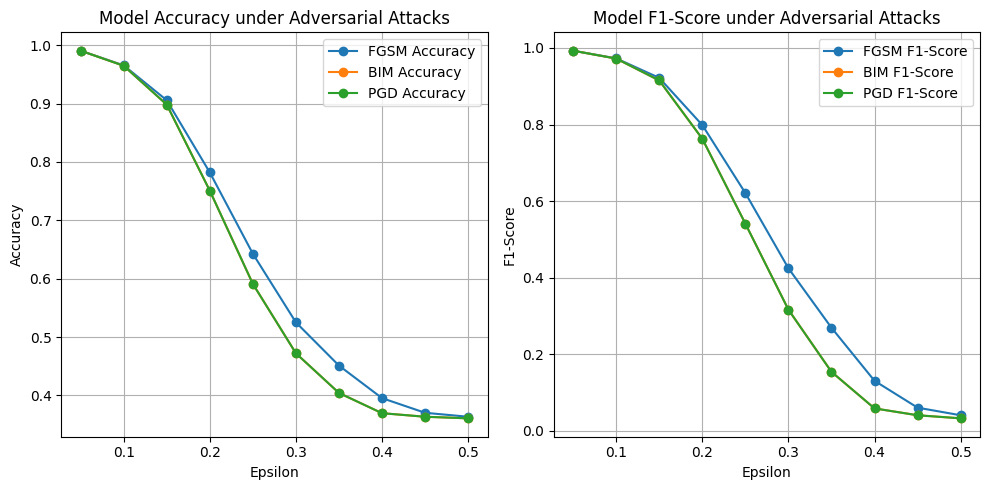

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

# Initialize lists to store metrics
epsilons_list = epsilons.numpy()  # Convert to NumPy array for plotting
fgsm_accuracies, fgsm_f1s = [], []
bim_accuracies, bim_f1s = [], []
pgd_accuracies, pgd_f1s = [], []
gn_accuracies, gn_f1s = [],[]
wb_accuracies,wb_f1s= [], []

# Perform attacks and evaluate
for epsilon in tqdm(epsilons, desc="Processing epsilon values"):
    fgsm_preds, fgsm_labels = [], []
    bim_preds, bim_labels = [], []
    pgd_preds, pgd_labels = [], []
    wb_preds,wb_labels = [], []

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.cpu()  # Convert labels to NumPy for metrics

        # Initialize attack methods for this epsilon value
        fgsm_attack = FastGradientMethod(estimator=classifier, eps=epsilon.item())
        bim_attack = BasicIterativeMethod(estimator=classifier, eps=epsilon.item(), max_iter=10, verbose=False)
        pgd_attack = ProjectedGradientDescentNumpy(estimator=classifier, eps=epsilon.item(), max_iter=10, verbose=False)
        # whitebox_attack = WhiteBoxAttack(model, epsilon=epsilon.item(), num_samples=50)


        # --- FGSM Attack ---
        adv_data_fgsm = fgsm_attack.generate(x=inputs.cpu().numpy())
        adv_data_fgsm = torch.tensor(adv_data_fgsm).to(device)
        adv_data_fgsm = adv_data_fgsm * mask + inputs * (1 - mask)
        adv_outputs_fgsm = model(adv_data_fgsm).squeeze()
        fgsm_pred = (adv_outputs_fgsm > 0.5).float().cpu().numpy()
        fgsm_preds.extend(fgsm_pred)
        fgsm_labels.extend(labels)

        # --- BIM Attack ---
        adv_data_bim = bim_attack.generate(x=inputs.cpu().numpy())
        adv_data_bim = torch.tensor(adv_data_bim).to(device)
        adv_data_bim = adv_data_bim * mask + inputs * (1 - mask)
        adv_outputs_bim = model(adv_data_bim).squeeze()
        bim_pred = (adv_outputs_bim > 0.5).float().cpu().numpy()
        bim_preds.extend(bim_pred)
        bim_labels.extend(labels)

        # --- PGD Attack ---
        adv_data_pgd = pgd_attack.generate(x=inputs.cpu().numpy())
        adv_data_pgd = torch.tensor(adv_data_pgd).to(device)
        adv_data_pgd = adv_data_pgd * mask + inputs * (1 - mask)
        adv_outputs_pgd = model(adv_data_pgd).squeeze()
        pgd_pred = (adv_outputs_pgd > 0.5).float().cpu().numpy()
        pgd_preds.extend(pgd_pred)
        pgd_labels.extend(labels)

        # # --- WhiteBox Attack ---
        # adv_data_whitebox = next(whitebox_attack.attack([(inputs.to('cuda'), labels.to('cuda'))]))
        # adv_outputs_whitebox = adv_data_whitebox.clone().detach().to(device)
        # adv_outputs_whitebox = model(adv_outputs_whitebox).squeeze()
        # wb_pred = (adv_outputs_whitebox > 0.5).float()
        # wb_preds.extend(wb_pred.cpu().numpy())
        # wb_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    def calculate_and_store_metrics(labels, preds, accuracies, f1s):
        accuracies.append(accuracy_score(labels, preds))
        f1s.append(f1_score(labels, preds))

    calculate_and_store_metrics(fgsm_labels, fgsm_preds, fgsm_accuracies, fgsm_f1s)
    calculate_and_store_metrics(bim_labels, bim_preds, bim_accuracies, bim_f1s)
    calculate_and_store_metrics(pgd_labels, pgd_preds, pgd_accuracies, pgd_f1s)
    # calculate_and_store_metrics(wb_labels, wb_preds, wb_accuracies, wb_f1s)



# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epsilons_list, fgsm_accuracies, label="FGSM Accuracy", marker="o")
plt.plot(epsilons_list, bim_accuracies, label="BIM Accuracy", marker="o")
plt.plot(epsilons_list, pgd_accuracies, label="PGD Accuracy", marker="o")
# plt.plot(epsilons_list, wb_accuracies, label="Targeted Random Noise Accuracy", marker="o")

plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Model Accuracy under Adversarial Attacks")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epsilons_list, fgsm_f1s, label="FGSM F1-Score", marker="o")
plt.plot(epsilons_list, bim_f1s, label="BIM F1-Score", marker="o")
plt.plot(epsilons_list, pgd_f1s, label="PGD F1-Score", marker="o")
# plt.plot(epsilons_list, wb_f1s, label="Targeted Random Noise F1-Score", marker="o")

plt.xlabel("Epsilon")
plt.ylabel("F1-Score")
plt.title("Model F1-Score under Adversarial Attacks")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("whitebox1")
plt.show()
